Let's start our Practical Session 2 : 


# Task 1

## Our first streaming using rate source


### Initialization SparkSession

In [1]:
import findspark
findspark.init()
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local").appName("Practical2").getOrCreate()

### Let’s first import the required libraries.

*   Pyspark functions 
*   Pyspark Types



In [2]:
from pyspark.sql.functions import * 
from pyspark.sql.types import * 
import pyspark.sql.functions as pysqlfun 
import pyspark.sql.types as pysqltyp

### Create streaming DataFrame


Let’s create our first Spark Streaming DataFrame using "rate" format. Here we have specified the format as rate and specified rowsPerSecond = 1 to generate 1 row for each micro-batch and load the data into initDF streaming DataFrame. 

In [3]:
initDF = (spark.readStream.format("rate").option("rowsPerSecond", 1).load())

### Check if DataFrame is streaming or Not.


In [4]:
print(initDF.isStreaming)

True


### Transformation

Perform transformation on initDF to generate another column result by just adding 1 to column value :


In [5]:
resultDF = initDF.withColumn("result", col("value") + lit(1))

### Output

In [6]:
query=resultDF.writeStream.outputMode("append").format("console").start()

In [7]:
query.awaitTermination(timeout=20)

False

In [8]:
query.stop()

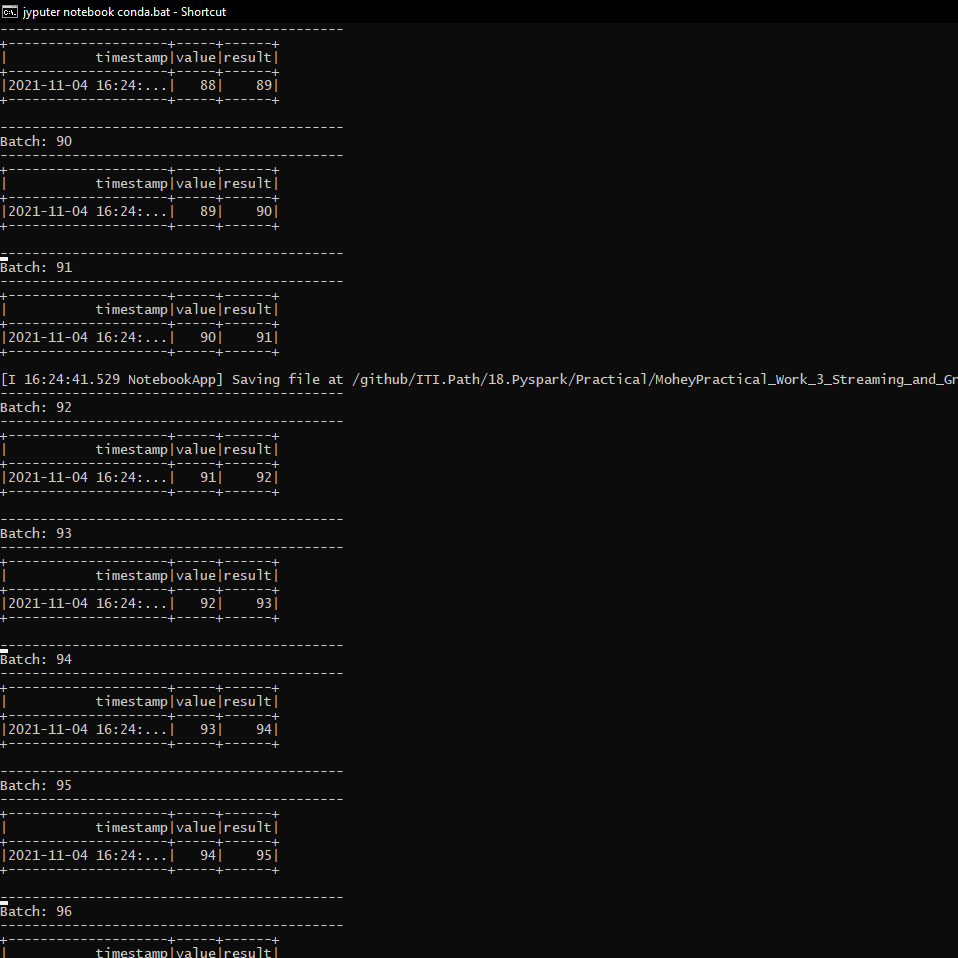
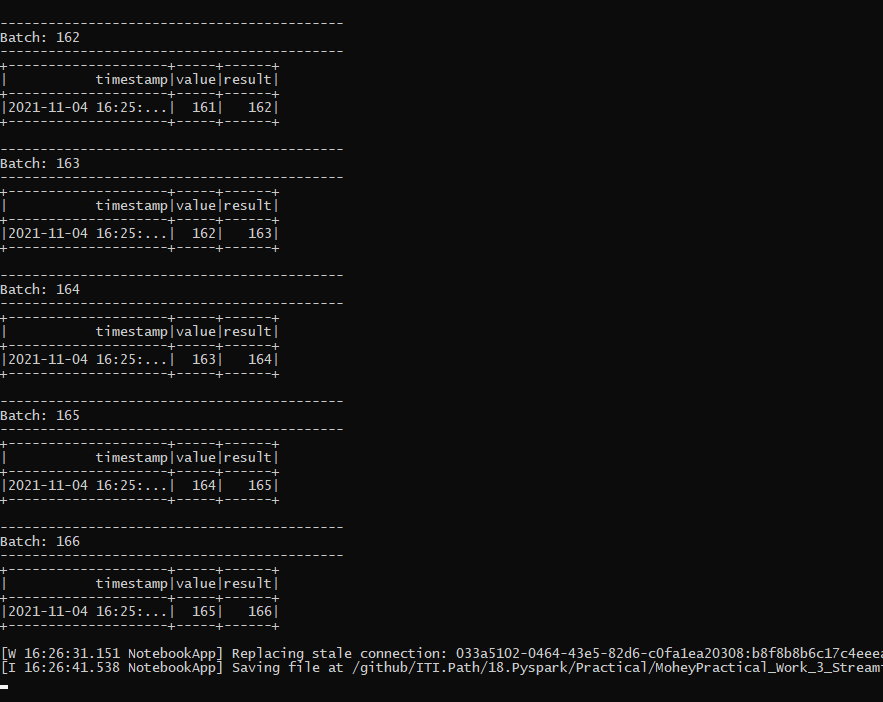

### Our Second streaming using rate source

### Create Streaming DataFrame

### Create Streaming DataFrame using socket source. Also, check if DataFrame isStreaming.


In [20]:
initDF = (spark.readStream.format("socket").option("host", "localhost")\
          .option("port","911").load())
print(initDF.isStreaming)

True


### Transformation: Word Count


Here we count words from a stream of data coming from this socket. Also, we check the schema of our streaming DataFrame.


In [21]:
wordCount = (initDF.select(explode(split(col("value")," "))\
                           .alias("words")).groupBy("words").count())

In [22]:
print(wordCount.printSchema())

root
 |-- words: string (nullable = true)
 |-- count: long (nullable = false)

None


In [23]:
query = wordCount.writeStream.outputMode("complete").format("console").start()

In [ ]:
query.awaitTermination(timeout=90)
query.stop()

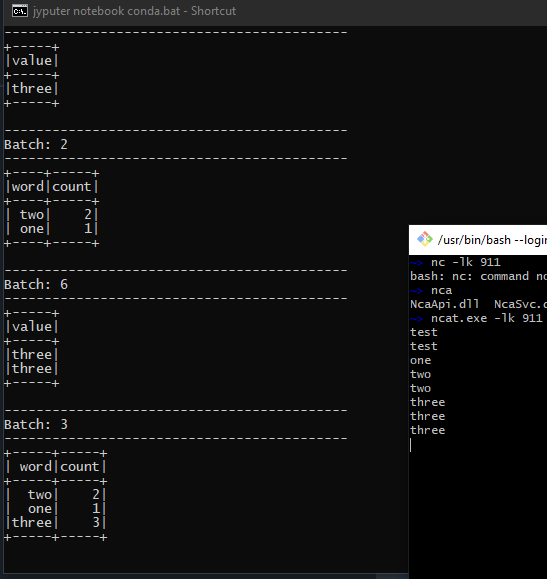

#### to check nc -lk 9999


### Input Sources — File

Schema Our data contains the fields Date,Open,High,Low,Close,Adj Close,Volume and we will extract Name from the filename using a custom function.
Here we define the schema and write a custom function to extract the stock ticker symbol.

In [3]:
schema = StructType([
  StructField("Date", StringType(), True),
  StructField("Open", DoubleType(), True),
  StructField("High", DoubleType(), True),
  StructField("Low", DoubleType(), True),
  StructField("Close", DoubleType(), True),
  StructField("Adjusted Close", DoubleType(), True),
  StructField("Volume", DoubleType(), True)
])


def getFileName():
    file_name = reverse(split(input_file_name(),"/")).getItem(0)
    file_name= split(file_name, "_").getItem(0)
    return file_name

#### Create Streaming DataFrame


Create a streaming DataFrame to read csv data from a specified directory "data/stream" and apply the above schema . We also specify the param maxFilesPerTrigger = 2 , which means our application will process a maximum of 2 CSV files in each batch. At the end, we create another column called Name using the function getFileName. That column contains stock ticker symbols like GOOGL, AMZN, AAPL etc.

In [4]:
# Create Streaming DataFrame by reading data from File Source.
initDF = (spark
  .readStream
  .format("csv")\
  .option("maxFilesPerTrigger", 2)
  .option("header", True)\
  .option("path", "Data")\
  .schema(schema)\
  .load()\
  .withColumn("FileName", getFileName()))

In [5]:
initDF.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adjusted Close: double (nullable = true)
 |-- Volume: double (nullable = true)
 |-- FileName: string (nullable = true)



#### Transformation

Group the data based on stock Name, Year and find the maximum value of the HIGH column.

In [6]:
stockDf = initDF.groupBy("FileName", year(col("Date").alias("Year"))).agg(pysqlfun.max("High").alias("Max"))

Can you build same transformation by Sql? 

In [9]:
initDF.createOrReplaceTempView("TempView")

# un SQL Query
query = """select year(Date) as Year, FileName, max(High) as Max 
            from TempView 
            group by FileName, Year"""
stockDf = spark.sql(query)

#### Output
Print the contents of streaming DatFrame to console using update mode.




Work with any dataset from data file 

In [10]:
query=stockDf.writeStream.outputMode("update").format("console")\
.trigger(processingTime='5 seconds').start()

In [11]:
query.awaitTermination(timeout=6)

False

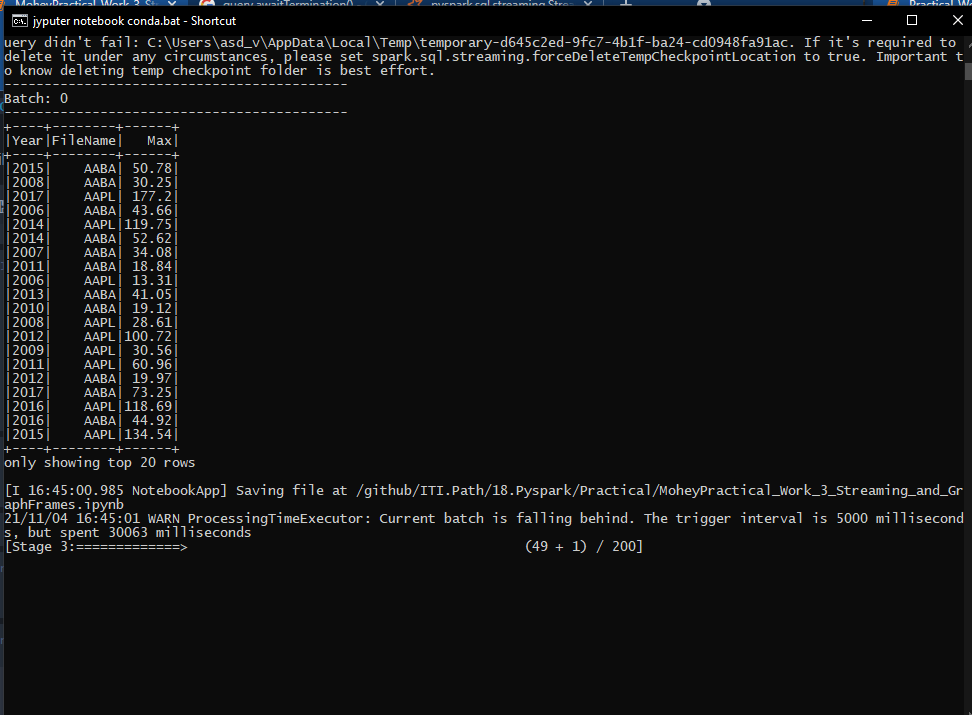
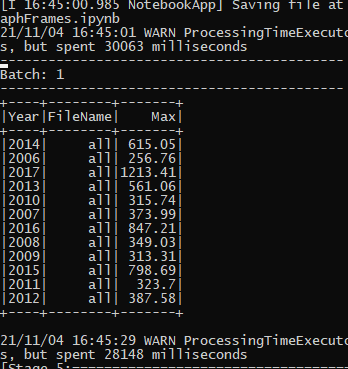
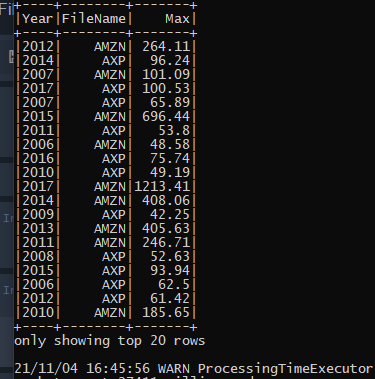


# Task 2

### Some aggregations transformation
Select "Name","Date", "Open", "High", "Low" and group by Name and Date and get the avg and use WithColumn to get current_timestamp 


In [13]:
spark = SparkSession\
      .builder\
      .master("local")\
      .appName("Task2")\
      .getOrCreate()

In [15]:
schema = StructType([
  StructField("Date", StringType(), True),
  StructField("Open", DoubleType(), True),
  StructField("High", DoubleType(), True),
  StructField("Low", DoubleType(), True),
  StructField("Close", DoubleType(), True),
  StructField("Adjusted Close", DoubleType(), True),
  StructField("Volume", DoubleType(), True)
])


def getFileName():
    file_name = reverse(split(input_file_name(),"/")).getItem(0)
    file_name= split(file_name, "_").getItem(0)
    return file_name
# Create Streaming DataFrame by reading data from File Source.
initDF = (spark
  .readStream
  .format("csv")\
  .option("maxFilesPerTrigger", 2)
  .option("header", True)\
  .option("path", "Data")\
  .schema(schema)\
  .load()\
  .withColumn("FileName", getFileName()))
initDF.printSchema()
resultDF = initDF.select("FileName","Date", "Open", "High", "Low").groupBy(col("FileName")
                , year(col("Date")).alias("Year")).agg(avg("High").alias("Avg"))\
                .withColumn("timestamp", current_timestamp())

root
 |-- Date: string (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adjusted Close: double (nullable = true)
 |-- Volume: double (nullable = true)
 |-- FileName: string (nullable = true)



### Checkpoints

In [16]:
query = resultDF.writeStream\
.outputMode("complete").option("checkpointLocation", "checkpoint").trigger(processingTime='5 seconds').format("console").start()

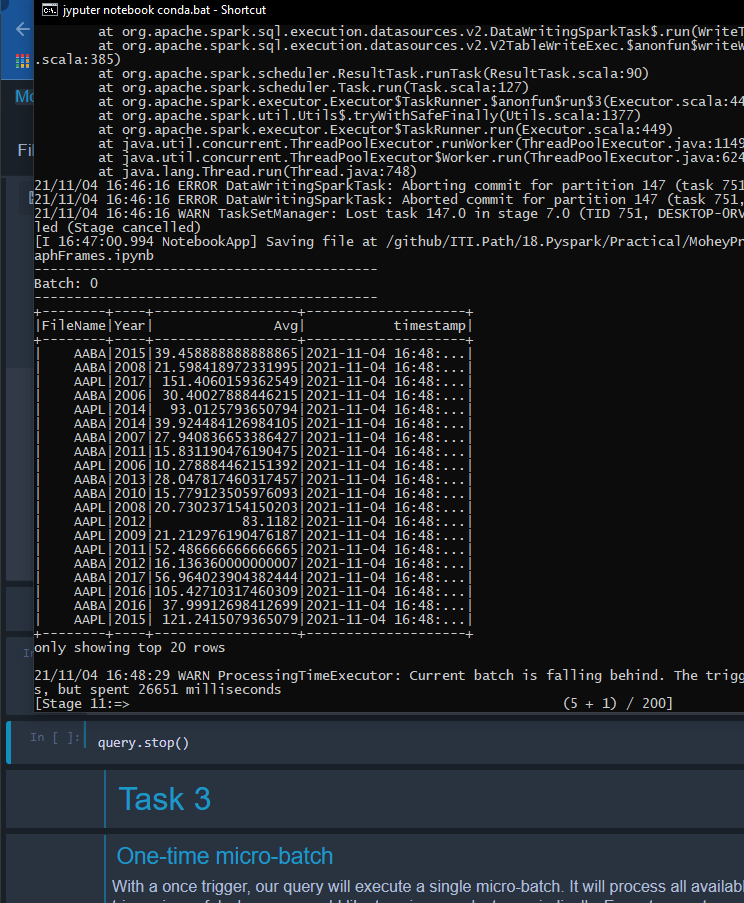

# Task 3

### One-time micro-batch
With a once trigger, our query will execute a single micro-batch. It will process all available data and then stop the application. This trigger is useful when you would like to spin-up a cluster periodically, 
Execute our streaming application with the once trigger.

In [19]:
query = resultDF.writeStream.outputMode("complete").option("checkpointLocation", "checkpoint")\
.format("console").trigger(once=True).start()


i dont know why and cant solve this ??
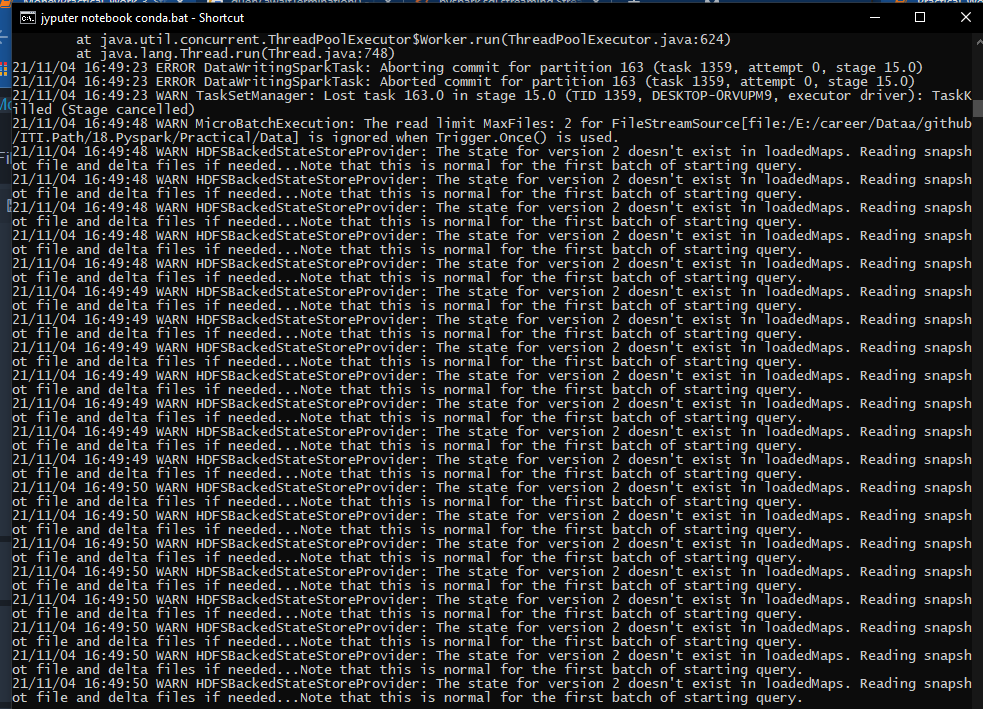

### Users can create GraphFrames from vertex and edge DataFrames.

* Vertex DataFrame: A vertex DataFrame should contain a special column named “id” which specifies unique IDs for each vertex in the graph.
* Edge DataFrame: An edge DataFrame should contain two special columns: “src” (source vertex ID of edge) and “dst” (destination vertex ID of edge).

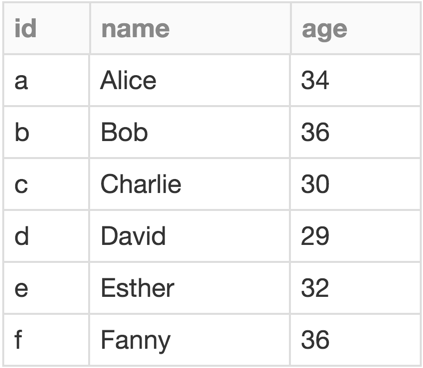

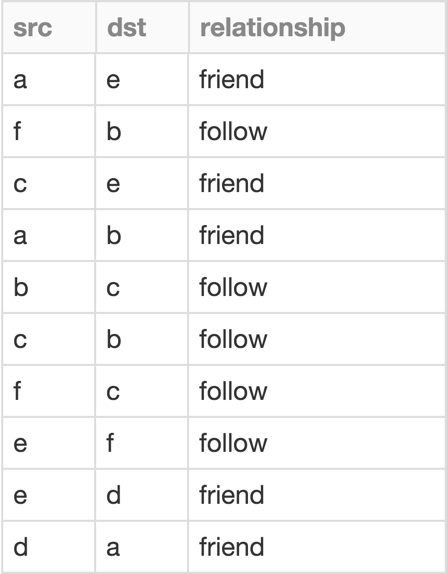

In [20]:
import findspark
findspark.init()
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
from graphframes import GraphFrame

### Create a GraphFrame from vertex and edge DataFrames

In [22]:
v = spark.createDataFrame([
  ("a", "Alice", 34),
  ("b", "Bob", 36),
  ("c", "Charlie", 30),
  ("d", "David", 29),
  ("e", "Esther", 32),
  ("f", "Fanny", 36)
], ["id", "name", "age"])


e = spark.createDataFrame([
  ("a", "e", "friend"),
  ("f", "b", "follow"),
  ("c", "e", "friend"),
  ("a", "b", "friend"),
  ("b", "c", "follow"),
  ("c", "b", "follow"),
  ("f", "c", "follow"),
  ("e", "f", "follow"),
    ("e","d","friend"),
    ("d","a","friend")
], ["src", "dst", "relationship"])
g = GraphFrame(v, e)

### Take a look at the DataFrames

Get vertices, edges, and check the number of edges of each vertex

In [23]:
g.vertices.show()
g.edges.show()

+---+-------+---+
| id|   name|age|
+---+-------+---+
|  a|  Alice| 34|
|  b|    Bob| 36|
|  c|Charlie| 30|
|  d|  David| 29|
|  e| Esther| 32|
|  f|  Fanny| 36|
+---+-------+---+

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  e|      friend|
|  f|  b|      follow|
|  c|  e|      friend|
|  a|  b|      friend|
|  b|  c|      follow|
|  c|  b|      follow|
|  f|  c|      follow|
|  e|  f|      follow|
|  e|  d|      friend|
|  d|  a|      friend|
+---+---+------------+



## Create UDF Functions 
convert your graph by mapping a function over the edges DataFrame that deletes the row if src ≥ dst return "Delete" else "Keep"

In [24]:
from pyspark.sql.functions import *
def delete_keep(src, dst):
    if src >= dst:
        return 'Delete'
    else : 
        return 'Keep'
    
udf1=udf(lambda a,b:delete_keep(a,b))

# Filtering and connected components

Check vertices when "age" greater than 30 and check edges "relationship" equal "friend" 

In [26]:
age_bigger_30=g.vertices.filter('age>30')
age_bigger_30.show()
relationship_friend=g.edges.filter('relationship=="friend"')
relationship_friend.show()

+---+------+---+
| id|  name|age|
+---+------+---+
|  a| Alice| 34|
|  b|   Bob| 36|
|  e|Esther| 32|
|  f| Fanny| 36|
+---+------+---+

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  e|      friend|
|  c|  e|      friend|
|  a|  b|      friend|
|  e|  d|      friend|
|  d|  a|      friend|
+---+---+------------+



GraphFrames requires you to set a directory where it can save checkpoints. Create such a folder in your working directory 

In [27]:
spark.sparkContext.setCheckpointDir('chkpnt')

Then, the connected components can easily be computed with the connectedComponents-function.


In [28]:
g.connectedComponents().show()

+---+-------+---+------------+
| id|   name|age|   component|
+---+-------+---+------------+
|  a|  Alice| 34|412316860416|
|  b|    Bob| 36|412316860416|
|  c|Charlie| 30|412316860416|
|  d|  David| 29|412316860416|
|  e| Esther| 32|412316860416|
|  f|  Fanny| 36|412316860416|
+---+-------+---+------------+



## Motif finding


Search for pairs of vertices a,b connected by edge e and pairs of vertices b,c connected by edge e2. It will return a DataFrame of all such structures in the graph

In [29]:
g.find("(a)-[e1]->(b);(b)-[e2]->(c)").show()

+----------------+--------------+----------------+--------------+----------------+
|               a|            e1|               b|            e2|               c|
+----------------+--------------+----------------+--------------+----------------+
|[c, Charlie, 30]|[c, e, friend]| [e, Esther, 32]|[e, f, follow]|  [f, Fanny, 36]|
|  [a, Alice, 34]|[a, e, friend]| [e, Esther, 32]|[e, f, follow]|  [f, Fanny, 36]|
|  [f, Fanny, 36]|[f, c, follow]|[c, Charlie, 30]|[c, e, friend]| [e, Esther, 32]|
|    [b, Bob, 36]|[b, c, follow]|[c, Charlie, 30]|[c, e, friend]| [e, Esther, 32]|
|  [d, David, 29]|[d, a, friend]|  [a, Alice, 34]|[a, e, friend]| [e, Esther, 32]|
|[c, Charlie, 30]|[c, e, friend]| [e, Esther, 32]|[e, d, friend]|  [d, David, 29]|
|  [a, Alice, 34]|[a, e, friend]| [e, Esther, 32]|[e, d, friend]|  [d, David, 29]|
| [e, Esther, 32]|[e, f, follow]|  [f, Fanny, 36]|[f, c, follow]|[c, Charlie, 30]|
|  [f, Fanny, 36]|[f, b, follow]|    [b, Bob, 36]|[b, c, follow]|[c, Charlie, 30]|
|[c,